# Whistle Detection and Analysis with AutomaticExtraction

This notebook demonstrates how to:
1. Load and process audio files
2. Detect whistles using a pre-trained model
3. Extract whistle contours from detections
4. Visualize and analyze the results
5. Cluster similar whistles

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat, wavfile


# Import from the correct paths
from AutomaticExtraction.src.extraction.contour import (
    vectorize_whistle_contours_from_file,
    split_wh_zones,
    distance_wh_zones,
    Extract_Whistles
)

from AutomaticExtraction.src.extraction.clustering import (
    cluster_whistles,
    extract_cluster_representatives,
    visualize_clusters
)

from AutomaticExtraction.src.utils.helpers import merge_consecutive_windows
from AutomaticExtraction.src.audio.spectrogram import compute_spectrogram

## 1. Load and Process Audio Data

First, we'll load a WAV file and its corresponding whistle detection predictions.

In [24]:
# Define paths to audio and prediction files
audio_path = "examples/example_audio.wav"  # Replace with your audio file
csv_path = "examples/example_audio/example_audio.wav_predictions.csv"  # Replace with your CSV file

# Load the predictions CSV file
csv_df = pd.read_csv(csv_path)
print(f"Loaded {len(csv_df)} whistle detections")
csv_df.head()

Loaded 23 whistle detections


,file_name,initial_point,finish_point,confidence
0,example_audio.wav,0.0,0.4,0.997502
1,example_audio.wav,0.4,0.8,1.000000
2,example_audio.wav,0.8,1.2,1.000000
3,example_audio.wav,1.2,1.6,0.997490
4,example_audio.wav,2.0,2.4,1.000000


## 2. Merge Consecutive Detection Windows

Consecutive detection windows are merged to form continuous whistle segments.

In [25]:
# Merge consecutive detection windows
detections_df = merge_consecutive_windows(csv_df)
print(f"Merged into {len(detections_df)} continuous whistle segments")
detections_df.head()

Merged into 9 continuous whistle segments


,file_name,initial_point,finish_point,confidence
0,example_audio.wav,0.0,1.6,0.998433
1,example_audio.wav,2.0,3.6,0.956850
2,example_audio.wav,4.0,4.8,0.995859
3,example_audio.wav,5.6,7.2,0.999398
4,example_audio.wav,7.6,8.4,0.917792


## 3. Extract Whistle Contours

Now we'll extract the frequency contours of the detected whistles.

In [26]:
# Extract whistle contours directly from the file
output_csv = "examples/Exp_11_Aug_2021_1549_channel_1/extracted_contours.csv"
wht, whf = vectorize_whistle_contours_from_file(audio_path, csv_path, output_csv, 
                                                window_size=3, delta=8, 
                                                min_freq=3500, max_freq=22000, 
                                                smoothing_window=5,
                                                noise_reduction=False, edge_detection=True)

print(f"Extracted {len(wht)} contour points")

Processing whistle zones:   0%|          | 0/23 [00:00<?, ?it/s]/export/home1/users/zfne/mustun/Documents/GitHub/Dolphins/AutomaticExtraction/src/extraction/contour.py:166: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_freqs = smoothed_freqs.fillna(method='bfill').fillna(method='ffill')
Processing whistle zones: 100%|██████████| 23/23 [00:01<00:00, 17.92it/s]

Extracted 828 contour points


## 4. Generate Spectrogram for Visualization

We'll create a spectrogram of the audio file to visualize the whistles.

In [27]:
# Load the audio file
fs, x = wavfile.read(audio_path)

# Generate spectrogram
specgram, freqs, times = compute_spectrogram(
    x,
    fs,
    stride_ms=10.0,
    window_ms=20.0,
    max_freq=30000,
    min_freq=1000
)

print(f"Generated spectrogram with shape {specgram.shape}")

Generated spectrogram with shape (581, 2139)


## 5. Visualize Whistle Contours on Spectrogram

Now we'll plot the extracted whistle contours on top of the spectrogram.

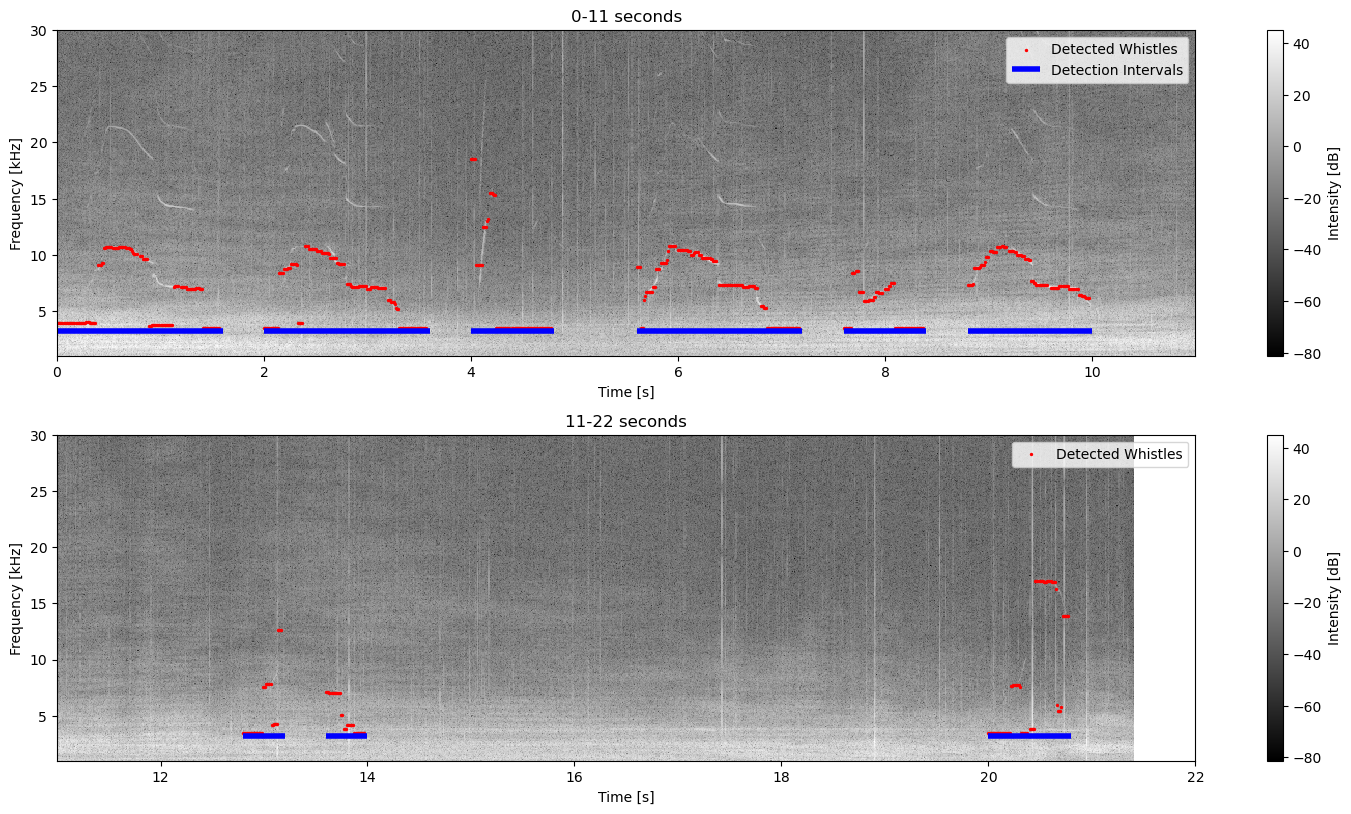

In [28]:
# Create a figure with 6 subplots (one for every 10 seconds)
plt.figure(figsize=(15, 24))
for i in range(2):
    ax = plt.subplot(6, 1, i+1)
    
    # Calculate time range for this subplot
    start_time = i * 11
    end_time = (i + 1) * 11
    
    # Plot spectrogram
    im = ax.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
    plt.colorbar(im, ax=ax, label='Intensity [dB]')
    
    # Plot vectorized whistles
    mask = (wht >= start_time) & (wht <= end_time)
    ax.scatter(wht[mask], whf[mask]/1000, c='r', s=2, label='Detected Whistles')
    
    # Add detection intervals
    for _, row in detections_df.iterrows():
        start = row['initial_point']
        end = row['finish_point']
        if start >= i * 11 and end <= (i + 1) * 11:  # Only plot intervals within this 10-second range
            ax.hlines(y=3.2, xmin=start, xmax=end, colors='blue', linewidth=4,
                      label='Detection Intervals' if _ == 0 else "")
    
    # Customize subplot
    ax.set_ylim(1, 30)
    ax.set_xlim(i * 11, (i + 1) * 11)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_title(f'{i * 11}-{(i + 1) * 11} seconds')
    ax.legend()

plt.tight_layout()
plt.show()

## 6. Prepare Contours for Clustering

Now we'll prepare the whistle contours for clustering by organizing them into segments.

In [29]:
# Split the contours into individual whistles
whistle_contours = split_wh_zones(wht, whf)
print(f"Split into {len(whistle_contours)} individual whistle contours")

Split into 3 individual whistle contours


## 7. Cluster Similar Whistle Contours

Now we'll cluster the whistle contours to find similar patterns.

In [37]:
filepath_annotation = "/users/zfne/mustun/Documents/GitHub/Dolphins/examples/templates/SW_Neo_2.mat"
annots = loadmat(filepath_annotation)
## Get frequency and time
annots_freqs = annots['whf'][0]
annots_times = annots['wht'][0]
annots_name = filepath_annotation.split('/')[-1].split('.')[0]

Distance = distance_wh_zones(wht, whf, annots_freqs, annots_times, n_jobs=36)
Wh, whistles_index = Extract_Whistles(Distance, whf, wht, annots_times, annots_freqs, 
                                      threshold=0.10, width=20, n_jobs=36)

100%|██████████| 828/828 [00:00<00:00, 2380.92it/s]


## 8. Visualize Representative Contours

Finally, we'll visualize the representative contours from each cluster.

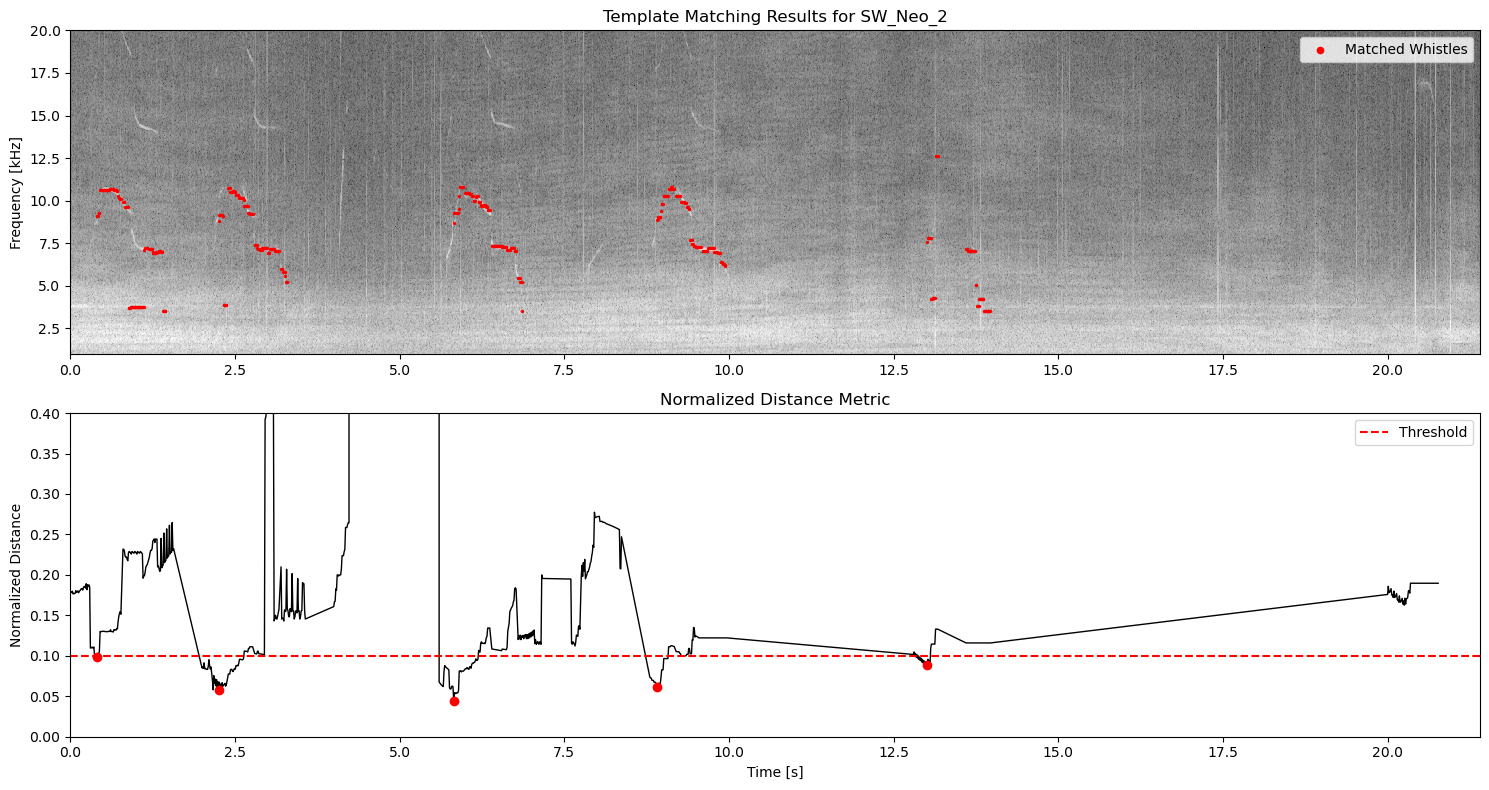

In [38]:
# Plot the extracted whistles from the template matching
plt.figure(figsize=(15, 8))

# Plot the spectrogram
ax1 = plt.subplot(2, 1, 1)
im1 = ax1.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')

# Plot the distance metric
ax2 = plt.subplot(2, 1, 2)
ax2.plot(wht, Distance, 'k-', linewidth=1)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Normalized Distance')
ax2.axhline(y=0.10, color='r', linestyle='--', label='Threshold')

# Mark the detected whistles on both plots
for i, whistle in enumerate(Wh):
    # Mark on distance plot
    whistle_time = whistle['onset']  # Use the onset time from the whistle
    whistle_index = np.argmin(np.abs(wht - whistle_time))  # Find closest index
    ax2.plot(wht[whistle_index], Distance[whistle_index], 'ro')
    
    # Mark on spectrogram
    ax1.scatter(whistle['wht'], whistle['whf']/1000, c='r', s=2)
    # Add a label for the first whistle only to avoid duplicate legend entries
    if i == 0:
        ax1.scatter([], [], c='r', s=20, label='Matched Whistles')

# Customize spectrogram plot
ax1.set_ylabel('Frequency [kHz]')
ax1.set_title(f'Template Matching Results for {annots_name}')
ax1.set_ylim(1, 20)
ax1.set_xlim(0, times[-1])
ax1.legend()

# Customize distance plot
ax2.set_title('Normalized Distance Metric')
ax2.legend()
ax2.set_xlim(0, times[-1])
ax2.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()


## 9. Save Results

Save the extracted contours and clustering results for future analysis.

In [32]:
# Create output directory if it doesn't exist
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Save contour points
contour_df = pd.DataFrame({
    'time': wht,
    'frequency': whf
})
contour_df.to_csv(os.path.join(output_dir, 'whistle_contours.csv'), index=False)

# Save clustering results if available
if 'labels' in locals() and len(labels) > 0:
    # Create a DataFrame with contour indices and their cluster labels
    cluster_df = pd.DataFrame({
        'contour_index': range(len(labels)),
        'cluster_label': labels
    })
    cluster_df.to_csv(os.path.join(output_dir, 'cluster_results.csv'), index=False)
    
    # Save representative contours
    for label, contour in representatives.items():
        rep_df = pd.DataFrame({
            'time': contour[:, 0],
            'frequency': contour[:, 1]
        })
        rep_df.to_csv(os.path.join(output_dir, f'cluster_{label}_representative.csv'), index=False)

print(f"Results saved to {output_dir}/")

Results saved to results/
